# Deepsurv

Deepsurv is a deep learning approach to the Cox Proportionnal Hazard (or Cox regression) model. 

We want to use it with clinical data and radiomics and compare the result to the classic Cox regression.

In [66]:
from utils import *
from pycox.models import CoxPH
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchtuples as tt
from torch import nn 
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [67]:
x, y = load_train_dataset()
fillna(x)

In [68]:
x.head()

Histology  Mstage  Nstage SourceDataset  Tstage  \
PatientID                                                                  
202                 Adenocarcinoma       0       0            l2       2   
371                     large cell       0       2            l1       4   
246        squamous cell carcinoma       0       3            l1       2   
240                            nos       0       2            l1       3   
284        squamous cell carcinoma       0       3            l1       4   

               age  original_shape_Compactness1  original_shape_Compactness2  \
PatientID                                                                      
202        66.0000                     0.027815                     0.274892   
371        64.5722                     0.023015                     0.188210   
246        66.0452                     0.027348                     0.265740   
240        59.3566                     0.026811                     0.255406   
284        71.0554                     0.023691                     0.199424   

           original_shape_Maximum3DDiameter  \
PatientID                                     
202                               48.559242   
371                               75.703368   
246                               70.434367   
240                               46.818800   
284                               53.795911   

           original_shape_SphericalDisproportion  ...  \
PatientID                                         ...   
202                                     1.537964  ...   
371                                     1.744961  ...   
246                                     1.555420  ...   
240                                     1.576120  ...   
284                                     1.711620  ...   

           original_glrlm_LongRunEmphasis  \
PatientID                                   
202                              1.457980   
371                              2.512125   
246                              4.096838   
240                              1.824328   
284                              2.652580   

           original_glrlm_GrayLevelNonUniformity  \
PatientID                                          
202                                   555.378594   
371                                  1766.619373   
246                                  3462.816344   
240                                   683.869792   
284                                   962.094760   

           original_glrlm_RunLengthNonUniformity  \
PatientID                                          
202                                 14592.303727   
371                                 22881.932686   
246                                 18773.106002   
240                                  7978.285176   
284                                  7520.054910   

           original_glrlm_RunPercentage  \
PatientID                                 
202                            0.891330   
371                            0.766032   
246                            0.644554   
240                            0.828138   
284                            0.734898   

           original_glrlm_LowGrayLevelRunEmphasis  \
PatientID                                           
202                                      0.003562   
371                                      0.002246   
246                                      0.001880   
240                                      0.002855   
284                                      0.006710   

           original_glrlm_HighGrayLevelRunEmphasis  \
PatientID                                            
202                                     954.749135   
371                                    1092.823724   
246                                     878.989601   
240                                     907.045929   
284                                    1513.420445   

           original_glrlm_ShortRunLowGrayLevelEmphasis  \
PatientID                                   

In [69]:
y.head()

SurvivalTime  Event
PatientID                     
202                1378      0
371                 379      1
246                 573      1
240                 959      0
284                2119      0

In [70]:
df_train = pd.concat([x, y], axis=1)

df_train = pd.get_dummies(df_train, columns=['Histology', 'SourceDataset'])
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)
print(df_train.shape)
df_train.head()

(240, 68)


Mstage  Nstage  Tstage      age  original_shape_Compactness1  \
PatientID                                                                 
202             0       0       2  66.0000                     0.027815   
371             0       2       4  64.5722                     0.023015   
246             0       3       2  66.0452                     0.027348   
240             0       2       3  59.3566                     0.026811   
284             0       3       4  71.0554                     0.023691   

           original_shape_Compactness2  original_shape_Maximum3DDiameter  \
PatientID                                                                  
202                           0.274892                         48.559242   
371                           0.188210                         75.703368   
246                           0.265740                         70.434367   
240                           0.255406                         46.818800   
284                           0.199424                         53.795911   

           original_shape_SphericalDisproportion  original_shape_Sphericity  \
PatientID                                                                     
202                                     1.537964                   0.650210   
371                                     1.744961                   0.573079   
246                                     1.555420                   0.642913   
240                                     1.576120                   0.634469   
284                                     1.711620                   0.584242   

           original_shape_SurfaceArea  ...  Event  Histology_Adenocarcinoma  \
PatientID                              ...                                    
202                       5431.333210  ...      0                         1   
371                      10369.568729  ...      1                         0   
246                      10558.818691  ...      1                         0   
240                       4221.412123  ...      0                         0   
284                       5295.900331  ...      0                         0   

           Histology_NSCLC NOS (not otherwise specified)  \
PatientID                                                  
202                                                    0   
371                                                    0   
246                                                    0   
240                                                    0   
284                                                    0   

           Histology_Squamous cell carcinoma  Histology_adenocarcinoma  \
PatientID                                                                
202                                        0                         0   
371                                        0                         0   
246                                        0                         0   
240                                        0                         0   
284                                        0                         0   

           Histology_large cell  Histology_nos  \
PatientID                                        
202                           0              0   
371                           1              0   
246                           0              0   
240                           0              1   
284                           0              0   

           Histology_squamous cell carcinoma  SourceDataset_l1  \
PatientID                                                        
202                                        0                 0   
371                                        0                 1   
246                                        1                 1   
240                                        0                 1   
284                                        1                 1   

           SourceDataset_l2  
PatientID                    
202                       1  


In [85]:
standardize = [([col], StandardScaler()) for col in df_train.columns if col not in ['SurvivalTime', 'Event'] and 'Histology' not in col and 'SourceDataset' not in col]
leave = [([col], None) for col in df_train.columns if 'Histology' in col or 'SourceDataset' in col]

x_mapper = DataFrameMapper(standardize + leave)

In [86]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')

get_target = lambda df: (df['SurvivalTime'].values, df['Event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
val = x_val, y_val
x_train.shape

(240, 66)

### Model

We decided to use a classic neural network with ReLU and Linear layers. Since we have quite a lot of features and not a lot of samples, we added 0.5 Dropout between each layers. 

In [95]:
net = nn.Sequential(
    nn.ReLU(),
    nn.Linear(in_features=66, out_features=32),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=16),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=8),
    nn.Dropout(0.5),
    nn.Linear(in_features=8, out_features=1)
)

In [96]:
model = CoxPH(net, tt.optim.Adam)

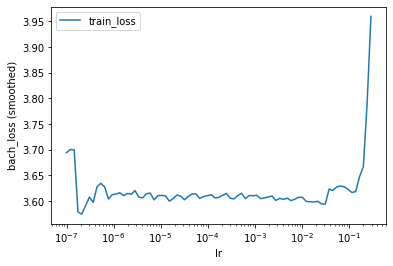

In [97]:
batch_size = 64
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [98]:
lrfinder.get_best_lr()

0.0001

In [99]:
model.optimizer.set_lr(0.0001)

In [100]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
#callbacks = []
verbose = True

In [101]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 3.5796,	val_loss: 3.5150
1:	[0s / 0s],		train_loss: 3.5921,	val_loss: 3.5144
2:	[0s / 0s],		train_loss: 3.5920,	val_loss: 3.5137
3:	[0s / 0s],		train_loss: 3.6318,	val_loss: 3.5131
4:	[0s / 0s],		train_loss: 3.6000,	val_loss: 3.5125
5:	[0s / 0s],		train_loss: 3.6295,	val_loss: 3.5119
6:	[0s / 0s],		train_loss: 3.5905,	val_loss: 3.5114
7:	[0s / 0s],		train_loss: 3.6057,	val_loss: 3.5108
8:	[0s / 0s],		train_loss: 3.5985,	val_loss: 3.5104
9:	[0s / 0s],		train_loss: 3.6146,	val_loss: 3.5099
10:	[0s / 0s],		train_loss: 3.5991,	val_loss: 3.5095
11:	[0s / 0s],		train_loss: 3.5812,	val_loss: 3.5090
12:	[0s / 0s],		train_loss: 3.5731,	val_loss: 3.5085
13:	[0s / 0s],		train_loss: 3.5901,	val_loss: 3.5081
14:	[0s / 0s],		train_loss: 3.5492,	val_loss: 3.5076
15:	[0s / 0s],		train_loss: 3.6159,	val_loss: 3.5072
16:	[0s / 0s],		train_loss: 3.5921,	val_loss: 3.5068
17:	[0s / 0s],		train_loss: 3.6325,	val_loss: 3.5064
18:	[0s / 0s],		train_loss: 3.5798,	val_loss: 3.5060
19:

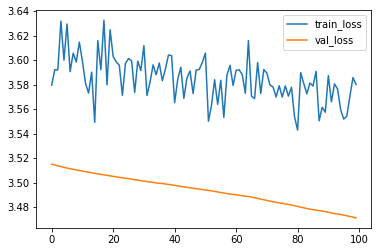

In [102]:
_ = log.plot()

The loss curves look promising, we don't notice any overfitting here

### Predictions

In [108]:
test = load_test_dataset()
fillna(test)
test = pd.get_dummies(test, columns=['Histology', 'SourceDataset'])
test.head()

Mstage  Nstage  Tstage      age  original_shape_Compactness1  \
PatientID                                                                 
13              0       0       4  44.3970                     0.028885   
155             0       3       1  63.3183                     0.031948   
404             0       2       2  64.7255                     0.015999   
407             0       0       2  65.3635                     0.031358   
9               0       0       2  50.0000                     0.017815   

           original_shape_Compactness2  original_shape_Maximum3DDiameter  \
PatientID                                                                  
13                            0.296451                        106.901824   
155                           0.362660                         18.814888   
404                           0.090945                        105.080921   
407                           0.349373                         46.968074   
9                             0.112759                         56.542020   

           original_shape_SphericalDisproportion  original_shape_Sphericity  \
PatientID                                                                     
13                                      1.499738                   0.666783   
155                                     1.402276                   0.713126   
404                                     2.223687                   0.449704   
407                                     1.419832                   0.704309   
9                                       2.069901                   0.483115   

           original_shape_SurfaceArea  ...  \
PatientID                              ...   
13                       29085.541425  ...   
155                        629.443640  ...   
404                      12509.265444  ...   
407                       4067.657372  ...   
9                         7093.365690  ...   

           original_glrlm_LongRunHighGrayLevelEmphasis  \
PatientID                                                
13                                         4654.031976   
155                                         639.621963   
404                                        7156.937667   
407                                        4776.549408   
9                                           400.015847   

           Histology_Adenocarcinoma  \
PatientID                             
13                                0   
155                               0   
404                               0   
407                               0   
9                                 1   

           Histology_NSCLC NOS (not otherwise specified)  \
PatientID                                                  
13                                                     0   
155                                                    0   
404                                                    0   
407                                                    0   
9                                                      0   

           Histology_Squamous cell carcinoma  Histology_adenocarcinoma  \
PatientID                                                                
13                                         0                         0   
155                                        0                         1   
404                                        0                         0   
407                                        0                         0   
9                                          0                         0   

           Histology_large cell  Histology_nos  \
PatientID                                        
13                            0              1   
155                           0              0   
404                           1              0   
407                           0              1   
9                             0              0   

           Histology_squamous cell carcinoma  SourceDataset_l1  \
PatientID                            

In [120]:
standardize = [([col], StandardScaler()) for col in test.columns if 'Histology' not in col and 'SourceDataset' not in col]
leave = [([col], None) for col in test.columns if 'Histology' in col or 'SourceDataset' in col]

test_x_mapper = DataFrameMapper(standardize + leave)
test_x = test_x_mapper.fit_transform(test).astype('float32')

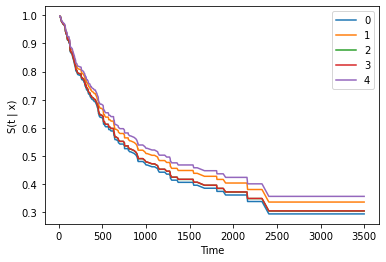

In [111]:
_ = model.compute_baseline_hazards()
pred = model.predict_surv_df(test_x)
pred.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

This graph is a visualization of the chances of surviving depending on the time for the first 5 patients. 

In [112]:
pred

0         1         2         3         4         5    \
duration                                                               
14        0.995542  0.996029  0.995667  0.995672  0.996241  0.996011   
20        0.995542  0.996029  0.995667  0.995672  0.996241  0.996011   
24        0.991070  0.992044  0.991320  0.991330  0.992467  0.992007   
25        0.986598  0.988056  0.986972  0.986987  0.988690  0.988002   
31        0.982125  0.984066  0.982623  0.982642  0.984910  0.983994   
...            ...       ...       ...       ...       ...       ...   
3078      0.294242  0.336394  0.304522  0.304935  0.356550  0.334723   
3222      0.294242  0.336394  0.304522  0.304935  0.356550  0.334723   
3251      0.294242  0.336394  0.304522  0.304935  0.356550  0.334723   
3259      0.294242  0.336394  0.304522  0.304935  0.356550  0.334723   
3500      0.294242  0.336394  0.304522  0.304935  0.356550  0.334723   

               6         7         8         9    ...       115       116  \
duration                                          ...                       
14        0.996104  0.995817  0.995748  0.995480  ...  0.996299  0.996136   
20        0.996104  0.995817  0.995748  0.995480  ...  0.996299  0.996136   
24        0.992194  0.991619  0.991481  0.990945  ...  0.992584  0.992257   
25        0.988281  0.987420  0.987214  0.986411  ...  0.988866  0.988375   
31        0.984366  0.983219  0.982945  0.981876  ...  0.985144  0.984491   
...            ...       ...       ...       ...  ...       ...       ...   
3078      0.343415  0.317314  0.311370  0.289225  ...  0.362337  0.346395   
3222      0.343415  0.317314  0.311370  0.289225  ...  0.362337  0.346395   
3251      0.343415  0.317314  0.311370  0.289225  ...  0.362337  0.346395   
3259      0.343415  0.317314  0.311370  0.289225  ...  0.362337  0.346395   
3500      0.343415  0.317314  0.311370  0.289225  ...  0.362337  0.346395   

               117       118       119       120       121       122  \
duration                                                               
14        0.995981  0.995695  0.995713  0.995359  0.995646  0.995873   
20        0.995981  0.995695  0.995713  0.995359  0.995646  0.995873   
24        0.991947  0.991376  0.991411  0.990705  0.991277  0.991731   
25        0.987911  0.987055  0.987108  0.986051  0.986907  0.987587   
31        0.983872  0.982734  0.982804  0.981398  0.982537  0.983442   
...            ...       ...       ...       ...       ...       ...   
3078      0.331935  0.306871  0.308357  0.279815  0.302726  0.322223   
3222      0.331935  0.306871  0.308357  0.279815  0.302726  0.322223   
3251      0.331935  0.306871  0.308357  0.279815  0.302726  0.322223   
3259      0.331935  0.306871  0.308357  0.279815  0.302726  0.322223   
3500      0.331935  0.306871  0.308357  0.279815  0.302726  0.322223   

               123       124  
duration                      
14        0.995729  0.995611  
20        0.995729  0.995611  
24        0.991443  0.991208  
25        0.987157  0.986805  
31        0.982869  0.982400  
...            ...       ...  
3078      0.309741  0.299884  
3222      0.309741  0.299884  
3251      0.309741  0.299884  
3259      0.309741  0.299884  
3500      0.309741  0.299884  

[225 rows x 125 columns]

This model returns the probability of surviving depending on time for each patient. To extract the survival time from this information, we decided to select the day at which the patient has less than 50% chance of surviving. 

In [122]:
result = pd.DataFrame(index=test.index.values, columns=['SurvivalTime', 'Event'])
result.index.name = 'PatientID'
i = 0
for ind, row in result.iterrows():
    for index, value in pred[i].items():
        if value<0.5 or index==3500:
            row['SurvivalTime'] = index
            row['Event'] = 'nan'
            break
    i+=1
result

SurvivalTime Event
PatientID                   
13                 896   nan
155               1134   nan
404                907   nan
407                907   nan
9                 1238   nan
...                ...   ...
66                 865   nan
132                907   nan
169               1002   nan
199                911   nan
274                903   nan

[125 rows x 2 columns]

In [119]:
working_dir = %pwd

result.to_csv(working_dir.replace('/notebooks', '/results/output_deepsurv.csv'), float_format='%.13f')

### Results

We noticed a lot of variance on the loss curves when we repeated the training multiple times, so we submitted different results corresponding to different runs of the method. The C_index varies from 0.54 to 0.70 on the test set. 